# X-ray Speckle Visibility Spectroscopy
The analysis module "skbeam/core/speckle" https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/speckle.py

In [1]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot

import skbeam.core.speckle as xsvs
import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

import numpy as np
import os, sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

### Easily switch between interactive and static matplotlib plots¶

In [2]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

### This data provided by Dr. Andrei Fluerasu
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini, C. Carona and A. Fluerasu ,
"Photon statistics and speckle visibility spectroscopy with partially coherent x-rays"
J. Synchrotron Rad., vol 21, p 1288-1295, 2014.

In [3]:
%run download.py

__file__
current_folder = /home/edill/dev/python/scikit-beam-examples/demos/speckle
current_folder = /home/edill/dev/python/scikit-beam-examples/demos/speckle


In [4]:
data_dir = "Duke_data/"
duke_rdata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_rdata.shape[0]):
    duke_data.append(duke_rdata[i] - duke_dark)
    
duke_ndata=np.asarray(duke_data)

# load the mask(s) and mask the data
mask1 = np.load(data_dir+"new_mask4.npy")
mask2 = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask1 + mask2)

In [5]:
mask_data = N_mask*duke_ndata

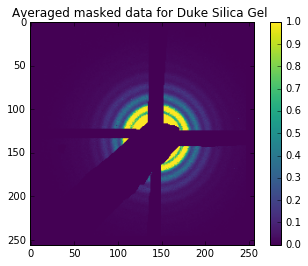

In [6]:
#  get the average image
avg_img = np.average(duke_ndata, axis=0)

# if matplotlib version 1.5 or later
if float('.'.join(mpl.__version__.split('.')[:2])) >= 1.5:
    cmap = 'viridis'
else:
    cmap = 'CMRmap'

# plot the average image data after masking
plt.figure()
plt.imshow(N_mask*avg_img, vmax=1e0, cmap=cmap)
plt.title("Averaged masked data for Duke Silica Gel ")
plt.colorbar()
plt.show()

### Create the Rings Mask¶
Use the skbeam.core.roi module to create Ring ROIs (ROI Mask).¶
(https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/roi.py)

In [7]:
inner_radius = 26  # radius of the first ring
width = 1        # width of each ring
spacing = 0      # no spacing between rings
num_rings = 4    # number of rings
center = (133, 143)   # center of the spckle pattern

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.],
       [ 29.,  30.]])

###  Convert the edge values of the rings to q ( reciprocal space)

In [8]:
dpix = 0.055  # The physical size of the pixels

lambda_ = 1.5498  # wavelength of the X-rays
Ldet = 2200.   #   # detector to sample distance

two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_val = utils.twotheta_to_q(two_theta, lambda_)

q_val

array([[ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929],
       [ 0.00293929,  0.00304064]])

In [9]:
q_ring = np.mean(q_val, axis=1)
q_ring

array([ 0.0026859 ,  0.00278726,  0.00288861,  0.00298997])

### Create a labeled array using roi.rings

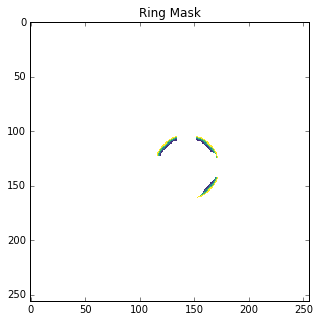

In [10]:
rings = roi.rings(edges, center, avg_img.shape)

images_sets = (mask_data, )

ring_mask = rings*N_mask

# plot the figure
fig, axes = plt.subplots(figsize=(5, 5))
axes.set_title("Ring Mask")
im = mpl_plot.show_label_array(axes, ring_mask, cmap=cmap)
plt.show()

### Find the brightest pixel in any ROI in any image in the image set.
Using roi_max_counts function from skbeam.core.roi module

In [11]:
max_cts = roi.roi_max_counts(images_sets, ring_mask)
max_cts

24

### Everything looks good, next X-ray speckle visibilty spectroscopy
This function will provide the probability density of detecting photons
for different integration time.
Using skbeam.core.speckle module

In [12]:
spe_cts_all, std_dev = xsvs.xsvs(images_sets, ring_mask, timebin_num=2,
                             number_of_img=30, max_cts=max_cts)

/home/edill/mc/envs/beam35/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(5, 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


### Find the integration times
using skbeam.core.utils.geometric_series

In [13]:
time_steps = utils.geometric_series(2, 30)
time_steps

[1, 2, 4, 8, 16]

## Get the mean intensity of each ring

In [14]:
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

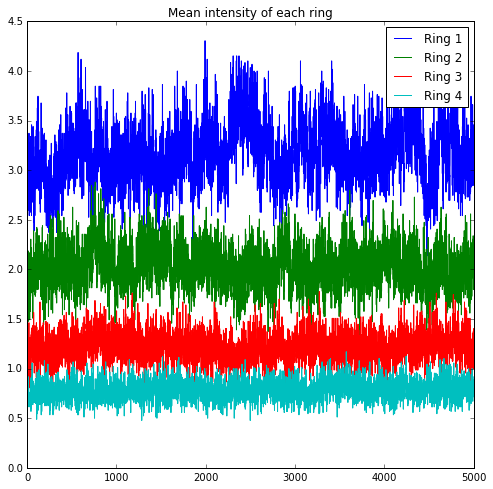

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Mean intensity of each ring")
for i in range(num_rings):
    plt.plot(mean_int_sets[:,i], label="Ring "+str(i+1))
plt.legend()    
plt.show()

In [16]:
mean_int_ring = np.mean(mean_int_sets, axis=0)
mean_int_ring

array([ 3.17503051,  2.03199322,  1.22062687,  0.78536136])

###  Get the normalized bin edges and bin centers for each integration time.

using skbeam.core.speckle.normalize_bin_edges

In [17]:
num_times = 6
num_rois=num_rings
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

### 1st q ring 0.0026859 (1/Angstroms)

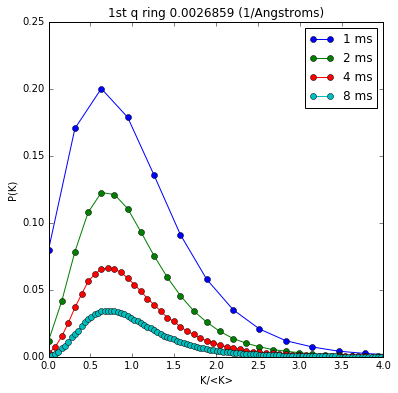

In [18]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring 0.0026859 (1/Angstroms)")
plt.show()

### 2nd q ring 0.00278726 (1/Angstroms)¶

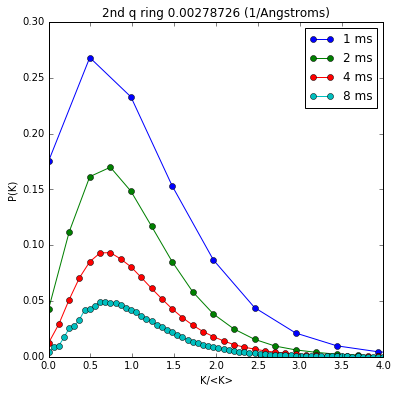

In [19]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 1][:-1], spe_cts_all[i, 1], '-o', label=str(time_steps[i])+" ms")
    axes.legend()
    axes.set_xlim(0, 4)
plt.title("2nd q ring 0.00278726 (1/Angstroms)")
plt.show()

## X-ray speckle visibilty spectroscopy(XSVS) for differnt time steps
This function will provide the probability 
density of detecting photons for different integration time. Using skbeam.core.speckle module

### Find the new integration times
using skbeam.core.utils.geometric_series

In [20]:
time_steps_5 = utils.geometric_series(5, 50)
time_steps_5

[1, 5, 25]

## XSVS results for new integartion times 1ms, 5ms and 25ms

In [21]:
p_K, std_dev_5 = xsvs.xsvs(images_sets, ring_mask, timebin_num=5,
                             number_of_img=50, max_cts=max_cts)

/home/edill/mc/envs/beam35/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(3, 5) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


### Plot the results for each Q ring

###1st q ring 0.0026859 (1/Angstroms)

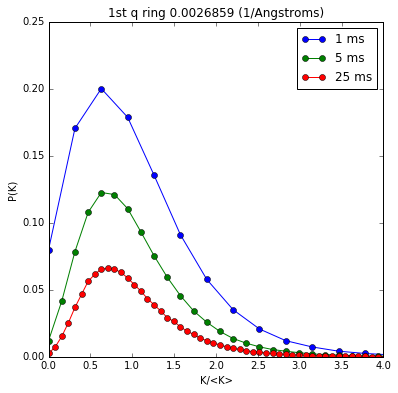

In [22]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(3):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], p_K[i, 0], '-o', label=str(time_steps_5[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring 0.0026859 (1/Angstroms)")
plt.show()

### 2nd q ring 0.00278726 (1/Angstroms)

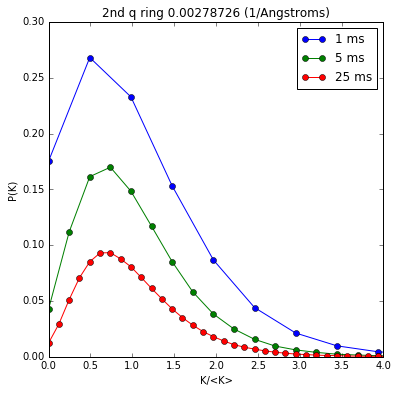

In [23]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(3):
    art, = axes.plot(norm_bin_edges[i, 1][:-1], p_K[i, 1], '-o', label=str(time_steps_5[i])+" ms")
    axes.legend()
    axes.set_xlim(0, 4)
plt.title("2nd q ring 0.00278726 (1/Angstroms)")
plt.show()

### 3rd q ring 0.00288861 (1/ Angstroms)

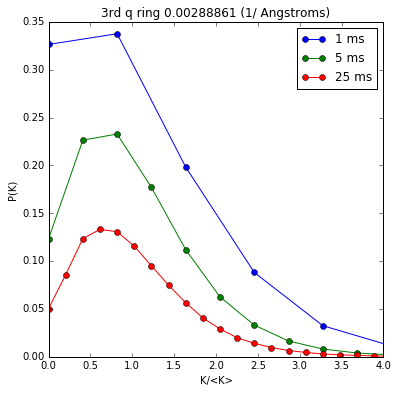

In [24]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(3):
    art, = axes.plot(norm_bin_edges[i, 2][:-1], p_K[i, 2], '-o', label=str(time_steps_5[i])+" ms" )
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("3rd q ring 0.00288861 (1/ Angstroms)")
plt.show()

### 4th q ring 0.0298997 (1/ Angstroms)

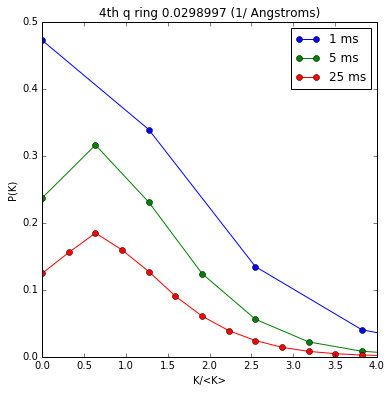

In [25]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(3):
    art, = axes.plot(norm_bin_edges[i, 3][:-1], p_K[i, 3], '-o', label=str(time_steps_5[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("4th q ring 0.0298997 (1/ Angstroms)")
plt.show()

In [26]:
import skbeam
print(skbeam.__version__)

0.0.6+41.g8aa4712
